In [73]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import warnings
from matplotlib.backends import backend_pdf
#import math
plt.style.use('my_sci')
warnings.filterwarnings("ignore")

### read data
The first data is downloaded from [the open tde catalog](https://tde.space/), and the second is copied from [Table A1](https://iopscience.iop.org/0004-637X/917/1/9/suppdata/apjabf4c3t4_ascii.txt?doi=10.3847/1538-4357/abf4c3) in Hung et al, 2021

In [89]:
import json
f = json.load(open('AT2019qiz.json'))
f2 = f['AT2019qiz']
df1 = pd.json_normalize(f2['photometry'])
df1.dropna(subset='e_magnitude', inplace=True)
df1 = df1.astype({"time": np.float64, "magnitude": np.float64, 'e_magnitude': np.float64})
print('Filters in data1:', set(df1['band']))
print('Telescope in data1:', set(df1['instrument']))
df1_fid_list = ['W2', 'M2', 'W1', 'U', 'r', 'i', 'g']
df1_datas = [df1[df1['band'] == fid] for fid in df1_fid_list]

df2 = pd.read_csv('19qiz_ascii.txt',sep=r'\t', skiprows=4, nrows=466)
df2['magerr'] = df2['Magnitude'].apply(lambda m: float(m[-4:]))
def get_mag(m):
    if m[0] == '>':
        return np.nan
    else:
        return float(m[:5])
df2['mag'] = df2['Magnitude'].apply(get_mag)
df2.dropna(subset='Magnitude', inplace=True)
print('Filters in data2:', set(df2['Filter']))
print('Telescope in data1:', set(df2['Telescope']))
fid_list = ['UVW2', 'UVM2', 'UVW1', 'u', 'g', 'r', 'i']
df2_datas = [df2[df2['Filter'] == fid].dropna(subset='mag') for fid in fid_list]

color_list = ['m', 'b', 'c', 'g', 'k', 'orange', 'red']

Filters in data1: {'orange', 'W1', 'W2', 'G', 'i', 'U', 'g', 'c', 'M2', 'r', 'o'}
Telescope in data1: {'GPC1', 'Astrometric', 'UVOT', 'ZTF', 'LCO', 'ACAM1', 'ZTF-Cam', 'ATLAS'}
Filters in data2: {'UVW1', 'i', 'UVM2', 'g', 'u', 'r', 'UVW2'}
Telescope in data1: {'Swope', 'Palomar 48 in', 'Siding Spring 1 m', 'Swift'}


Text(0, 0.5, 'mag (arbitrary)')

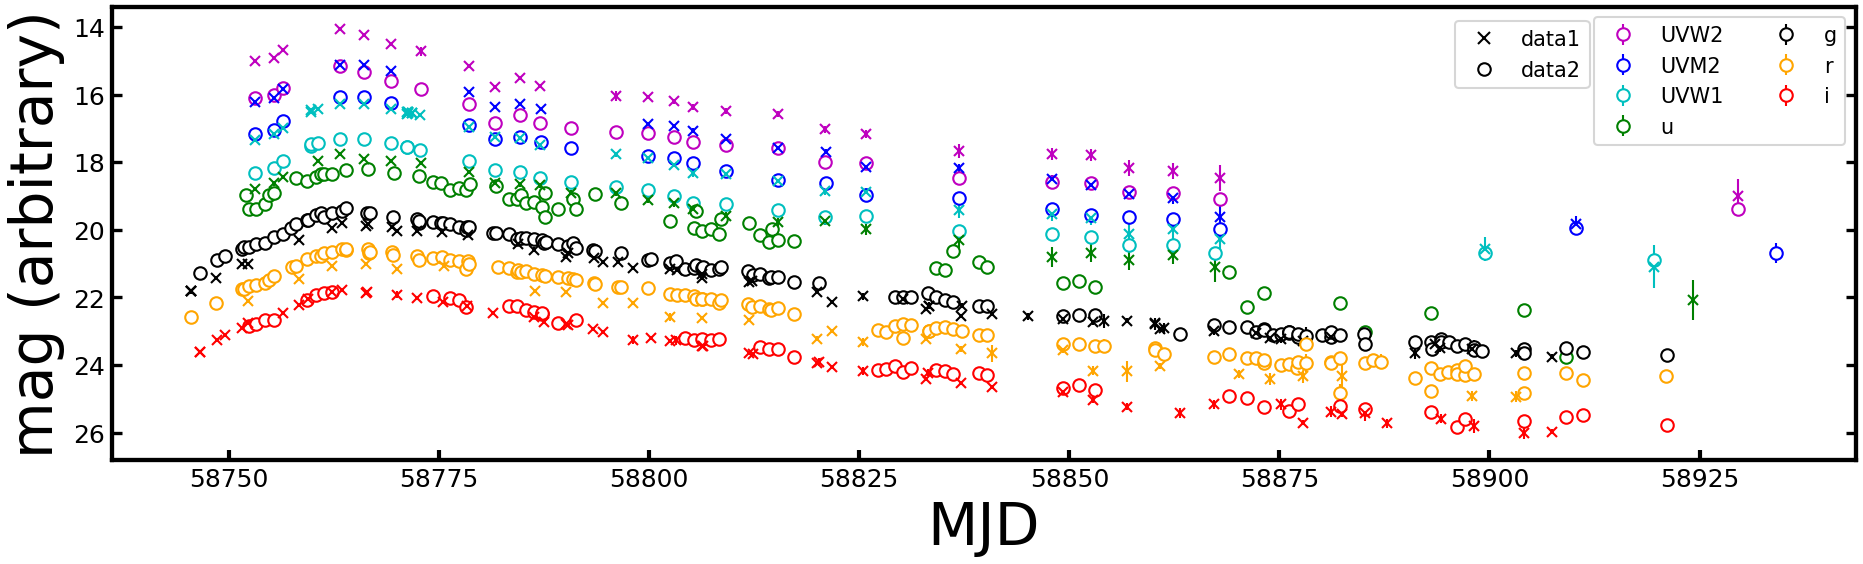

In [90]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.invert_yaxis()
ax2 = ax.twiny()
ax2.get_xaxis().set_visible(False)
for nn in range(7):
    #f = interp1d(np.array(df1_datas[nn]['time']), np.array(df1_datas[nn]['magnitude']), bounds_error=False)
    #mag_n = f(df2_datas[nn][df2_datas[nn]['MJD'] < 58850]['MJD'])
    #ind = ~np.isnan(mag_n)
    #move = np.mean(np.array(df2_datas[nn][df2_datas[nn]['MJD'] < 58850]['mag'])[ind] - mag_n[ind])

    ax.errorbar(df2_datas[nn]['MJD'], df2_datas[nn]['mag']+nn, yerr=df2_datas[nn]['magerr'], 
            mfc='w', fmt='o', color = color_list[nn], label = fid_list[nn])

    ax.errorbar(df1_datas[nn]['time'], df1_datas[nn]['magnitude']+nn, df1_datas[nn]['e_magnitude'], fmt = 'x', mfc='w',
                 color = color_list[nn], ms=5)

for fmt, label in zip(['x', 'o'], ['data1', 'data2']):
    ax2.errorbar(np.NaN, np.NaN, fmt=fmt,
            label=label, color='black', mfc='w')

ax.legend(ncol=2)
ax2.legend(loc=(0.77, 0.82))
ax.set_xlabel('MJD')
ax.set_ylabel('mag (arbitrary)')
#ax.add_artist(legend1, loc=2)

**Here we have _UVW2, UVM2, UVW1, u, r, i, g_ band light curves in our ```df1_datas``` and ```df2_datas```. Due to different data reduction, the two datasets show slight deviations.   
Followed _Hung et al, 2021_, we interpolate optical _ugri_ band light curve to the epoch which having all three UV band photometry, as UV flux is pivotal in blackbody emission fit**

In [91]:
for data in df2_datas:
    data['d'] = [int(d) for d in data['MJD']]     

# join the 3 UV light curve
df_j = df2_datas[0].join(df2_datas[1].set_index('d'), on='d', lsuffix='0', rsuffix='1', how='inner')
df_j = df_j.join(df2_datas[2].set_index('d'), on='d', rsuffix='2', how='inner')

# days with all 3 UV band photometry
d_arr = np.array(df_j['d'])

# rename the DataFrame which we will use
df_fit = df_j[['d', 'mag0', 'mag1', 'mag']]
df_fit.columns = ['mjd', 'UVW2', 'UVM2', 'UVW1']

# interpolate optical light curve to the d_arr
for nn in range(3, 7):
    data = df2_datas[nn]
    f = interp1d(np.array(data['MJD']), np.array(data['mag']), bounds_error=False)
    mag_interp = f(d_arr)
    df_fit[fid_list[nn]] = mag_interp
    
df_fit.set_index(np.arange(len(df_fit)), inplace=True)

**Now we can to fit the $ T_{bb} $ and $ R_{bb} $ using constructed multi-epoch SED**

In [186]:
# build blackbody function, assuming the emittion region is a photosphere, indicating the emittion area equal to 4 pi r**2
from astropy import units as u 
from astropy.constants import h,c,k_B, sigma_sb, G
#print( h.to(u.erg*u.s), k_B.to(u.erg/u.K), sigma_sb.to(u.erg/u.s/u.cm**2/u.K**4))
sigma_sb = sigma_sb.to(u.erg/u.s/u.cm**2/u.K**4).value
h = h.to(u.erg*u.s).value
c = c.to(u.cm/u.s).value
k = k_B.to(u.erg/u.K).value

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.4, Om0=0.315)
z = 0.0151
D_L = cosmo.luminosity_distance(z).to(u.cm).value

def log_my_bb(freq, T):
    return 2 * h * freq**3 / c**2 / (np.exp(h*freq/(k*T))-1) 

def photo_sphere(freq, T, radius):
    log_bb = log_my_bb(freq, T)
    return np.log10(log_bb) + np.log10(4 * np.pi) + 2*np.log10(radius)

In [187]:
# Let's fit
tem_arr = np.zeros(len(df_fit))
rad_arr = np.zeros(len(df_fit))

lam_arr = np.array((2054.61, 2246.43, 2580.74, 3467.05, 4758.76, 6389.72, 7927.51)) / (1+z)
freq_arr = 3e18 / lam_arr

for ii in range(len(df_fit)):
    y = 10**((np.array(df_fit.loc[ii][fid_list]) + 48.6) / -2.5) * 4 * np.pi * D_L**2
    (popt, popr), pcov = curve_fit(photo_sphere, freq_arr, np.log10(y), p0=(1e4, 1e14))
    tem_arr[ii] = popt
    rad_arr[ii] = popr
# finish fit

In [242]:
from ipywidgets import interact
freq_ref = np.logspace(14, 15.7)
def plot_fit(ii):
    log_lum_ref = photo_sphere(freq_ref, tem_arr[ii], rad_arr[ii])
    fig, ax = plt.subplots(figsize=(4,3))
    ax.plot(freq_ref, log_lum_ref+np.log10(freq_ref))
    y = 10**((np.array(df_fit.loc[ii][fid_list]) + 48.6) / -2.5) * 4 * np.pi * D_L**2
    ax.errorbar(freq_arr, np.log10(y)+np.log10(freq_arr), fmt='o')
    ax.text(0.7, 0.8, f"mjd:{df_fit['mjd'][ii]}", transform=ax.transAxes)
    ax.set_ylabel(r'$\nu L_{\nu}$')
    ax.set_xlabel(r'$\nu$')
interact(plot_fit, ii=(0, 23))

interactive(children=(IntSlider(value=11, description='ii', max=23), Output()), _dom_classes=('widget-interact…

<function __main__.plot_fit(ii)>

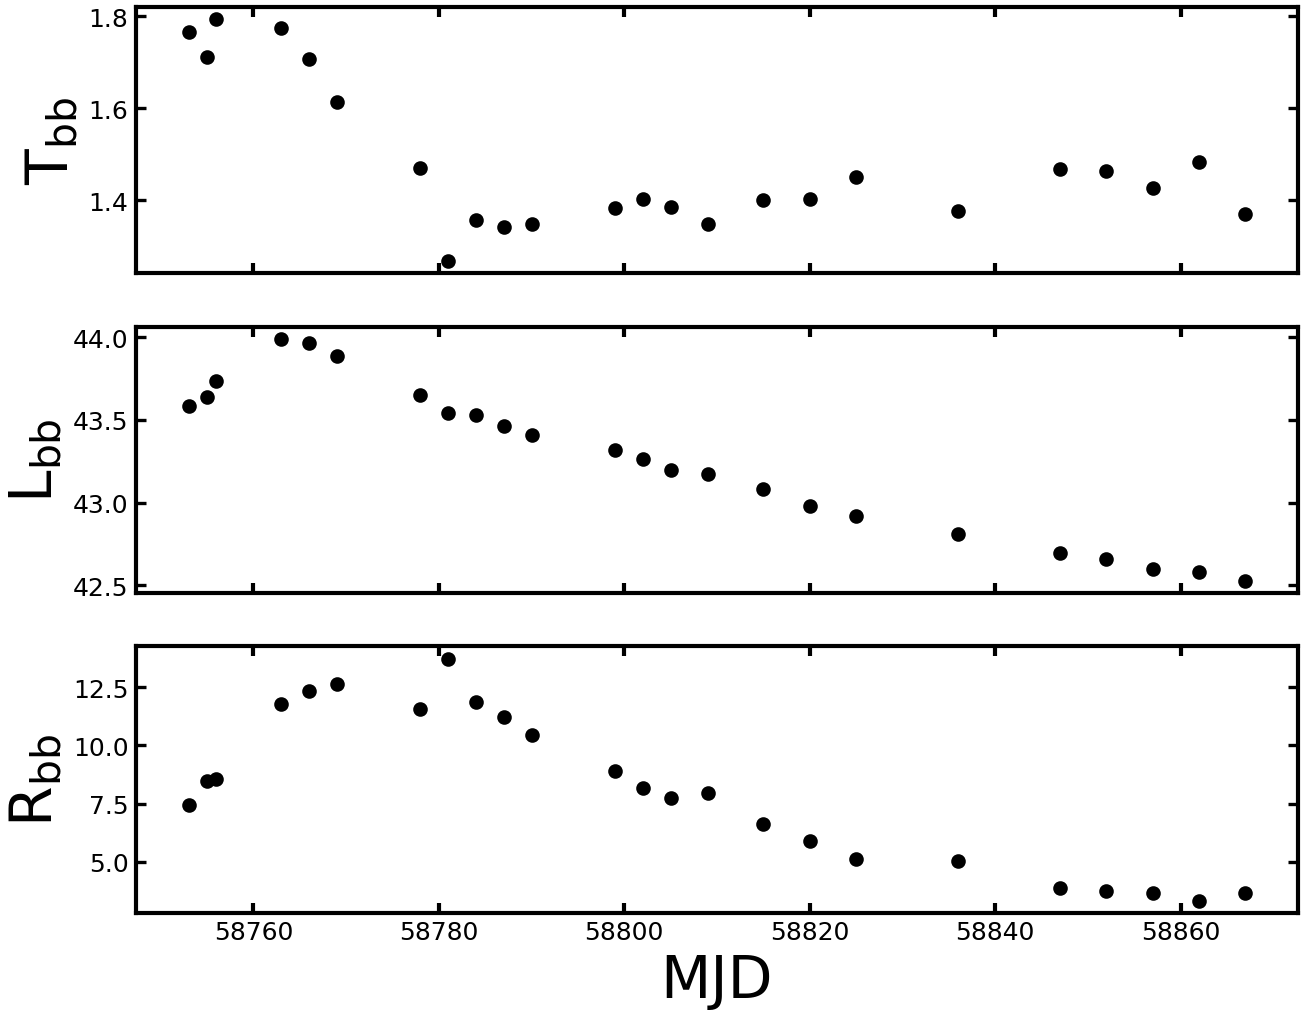

In [246]:
fig, axes = plt.subplots(3,1, figsize=(10,8))

axes[0].errorbar(df_fit['mjd'], tem_arr/1e4, fmt='o', color='k')
#axes[0].set_ylim(1.1, 2.0)
axes[0].set_ylabel(r'$\mathrm{T_{bb}}$')

Lum_arr = np.log10(4*np.pi) + 2*np.log10(rad_arr) + np.log10(sigma_sb) + 4*np.log10(tem_arr) 
axes[1].errorbar(df_fit['mjd'], Lum_arr, fmt='o', color='k')
axes[1].set_ylabel(r'$\mathrm{L_{bb}}$')

axes[2].errorbar(df_fit['mjd'], rad_arr/1e14, fmt='o', color='k')
axes[2].set_ylabel(r'$\mathrm{R_{bb}}$')
axes[2].set_xlabel(r'MJD')

for ax in axes[:2]:
    ax.set_xticklabels([])

**<font color = red>Sadly, the results from our fit is different from _Hung et al, 2021_, in which the emitting radius is a little smaller.</font> But we detect the rapid temperature cooling and invariability of emitting radius near the peak**